In [1]:
from pathlib import Path

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.offline
from plotly.subplots import make_subplots
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler

from pptoolbox.platform import preprocess, WAVELENGTHS_3NM_V1
from pptoolbox.preprocessing import SNV, MSC, SavitzkyGolay, Detrend
from pptoolbox.visualization import (plot_spectra, plot_loadings, plot_scree, fit_pca,
                                               generate_pc_df, plot_svp, initialize_theme,spectral_vector_properties)

from sklearn.feature_selection import f_classif, mutual_info_classif, chi2

# plotly.offline.init_notebook_mode()
# qualitative_cmap, diverging_cmap, light_cmap = initialize_theme()

# import data

In [2]:
pulldate = "250317"

datafolder_path = Path ("../data/")
raw_csv = datafolder_path / f"raw/spectra_{pulldate}.csv"
spectra_df = pd.read_csv(raw_csv)

label_csv = datafolder_path / f"processed/label_{pulldate}.csv"
info_df = pd.read_csv(label_csv)

spectra_df.shape, info_df.shape

((883, 13), (135, 3))

In [3]:
info_df

,lot_id,lot_name,Rancidity (Class-text)
0,76751,SH3639-598,2-Mild
1,76752,SH3639-A,1-Pass
2,76753,SH3639-397,1-Pass
3,76754,SH3639-486,3-Rancid
4,76755,SH3639-208,2-Mild
...,...,...,...
130,87488,B857,2-Mild
131,87489,B847,2-Mild
132,87490,B852,2-Mild
133,87491,B844,2-Mild


In [4]:
datasets = {
    'full': {
        'info_df_og': info_df.reset_index().drop(columns=['lot_name']).set_index('lot_id')
    }
}

In [5]:
spectra_df

,lot_id,specimen_id,lot_name,date_scanned,analyser_id,company_id,product_id,product_name,raw_data,dark_ref_data,white_ref_data,dark_ref_scan_time,white_ref_scan_time
0,71700,434452,A,1717659544,26,1281,6624,Shortening (Rancidity),"[{""wavelength"": 332.4588623046875, ""reflectanc...","[0.11375, 1.79359375, 0.88171875, 2.24640625, ...","[0.094375, 1.535234375, 0.757265625, 1.9614062...",1717659346,1717659386
1,85894,503651,B802 16112024,1733302683,26,1281,6624,Shortening (Rancidity),"[{""wavelength"": 332.4588623046875, ""reflectanc...","[9.490078125, 15.2721875, 13.60796875, 15.0438...","[8.804375, 15.297265625, 13.0853125, 14.882265...",1733301770,1733301799
2,85894,503653,B802 16112024,1733302704,26,1281,6624,Shortening (Rancidity),"[{""wavelength"": 332.4588623046875, ""reflectanc...","[9.490078125, 15.2721875, 13.60796875, 15.0438...","[8.804375, 15.297265625, 13.0853125, 14.882265...",1733301770,1733301799
3,85894,503655,B802 16112024,1733302729,26,1281,6624,Shortening (Rancidity),"[{""wavelength"": 332.4588623046875, ""reflectanc...","[9.490078125, 15.2721875, 13.60796875, 15.0438...","[8.804375, 15.297265625, 13.0853125, 14.882265...",1733301770,1733301799
4,85894,503656,B802 16112024,1733302762,26,1281,6624,Shortening (Rancidity),"[{""wavelength"": 332.4588623046875, ""reflectanc...","[9.490078125, 15.2721875, 13.60796875, 15.0438...","[8.804375, 15.297265625, 13.0853125, 14.882265...",1733301770,1733301799
...,...,...,...,...,...,...,...,...,...,...,...,...,...
878,71696,434409,Shortening 3,1717657348,26,1281,6624,Shortening (Rancidity),"[{""wavelength"": 332.4588623046875, ""reflectanc...","[1.708046875, 6.724375, 4.746171875, 6.5246875...","[1.3203125, 6.293515625, 4.060625, 5.988671875...",1717656752,1717656795
879,71697,434410,Shortening 4,1717657389,26,1281,6624,Shortening (Rancidity),"[{""wavelength"": 332.4588623046875, ""reflectanc...","[1.708046875, 6.724375, 4.746171875, 6.5246875...","[1.3203125, 6.293515625, 4.060625, 5.988671875...",1717656752,1717656795
880,71697,434411,Shortening 4,1717657423,26,1281,6624,Shortening (Rancidity),"[{""wavelength"": 332.4588623046875, ""reflectanc...","[1.708046875, 6.724375, 4.746171875, 6.5246875...","[1.3203125, 6.293515625, 4.060625, 5.988671875...",1717656752,1717656795
881,71698,434412,Shortening 5,1717657483,26,1281,6624,Shortening (Rancidity),"[{""wavelength"": 332.4588623046875, ""reflectanc...","[1.708046875, 6.724375, 4.746171875, 6.5246875...","[1.3203125, 6.293515625, 4.060625, 5.988671875...",1717656752,1717656795


# preprocess lots

In [6]:
datasets['full'].keys()

dict_keys(['info_df_og'])

In [7]:
for dataset in datasets:
    print(f'Processing {dataset} dataset')
    info_df_copy = datasets[dataset]['info_df_og'].reset_index()
    raw_df, label_df = preprocess(spectra_df, info_df_copy, wavelengths = WAVELENGTHS_3NM_V1)

    label_df = pd.merge(label_df.drop_duplicates(), spectra_df[["lot_id","date_scanned"]], on='lot_id', how='left').drop(columns=['index'])

    datasets[dataset]['raw_df'] = raw_df
    datasets[dataset]['label_df'] = label_df

    print(f'Shapes: {raw_df.shape}, {label_df.shape}')

Processing full dataset
Shapes: (542, 191), (542, 3)


In [8]:
datasets['full']['label_df']

,lot_id,Rancidity (Class-text),date_scanned
0,76751,2-Mild,1725014022
1,76751,2-Mild,1725014045
2,76751,2-Mild,1725014065
3,76751,2-Mild,1725014083
4,76752,1-Pass,1725014709
...,...,...,...
537,87491,2-Mild,1735295645
538,87492,2-Mild,1735295678
539,87492,2-Mild,1735295699
540,87492,2-Mild,1735295723


In [9]:
for dataset in datasets:
    print(f'Processing {dataset} dataset')
    label_df = datasets[dataset]['info_df_og']

    param_label_map = {}

    for col in label_df.columns:
        if label_df[col].dtype == 'float64':
            param_label_map[col] = 'reg'
        elif label_df[col].dtype == 'object':
            param_label_map[col] = 'clf'

    datasets[dataset]["param_label_map"] = param_label_map

Processing full dataset


In [10]:
for dataset in datasets:
    print(datasets[dataset]['param_label_map'])

{'Rancidity (Class-text)': 'clf'}


# filter data

In [11]:
# create a new dict selections
selections = datasets.copy()

# Check for Outliers

In [12]:
cmap=sns.color_palette()
PREPROCESSING = 'No Preprocessing'

Processing full dataset


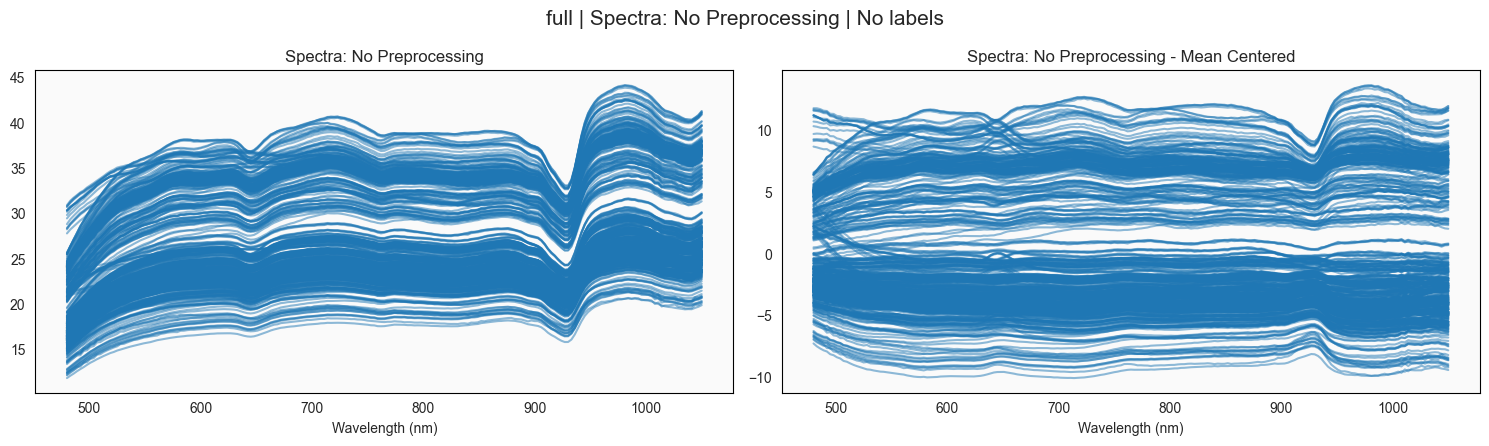

In [13]:
for selection in selections:
    print(f'Processing {selection} dataset')

    output_dir = Path(f"../data/visualisation/{selection}/")
    output_dir.mkdir(exist_ok=True, parents=True)

    selected_df = selections[selection]['raw_df']
    SAMPLE_TYPE = f'{selection}'

    plot_spectra(selected_df, labels=None,
                spec_prep=PREPROCESSING,
                sample_type=SAMPLE_TYPE,
                cmap=cmap);

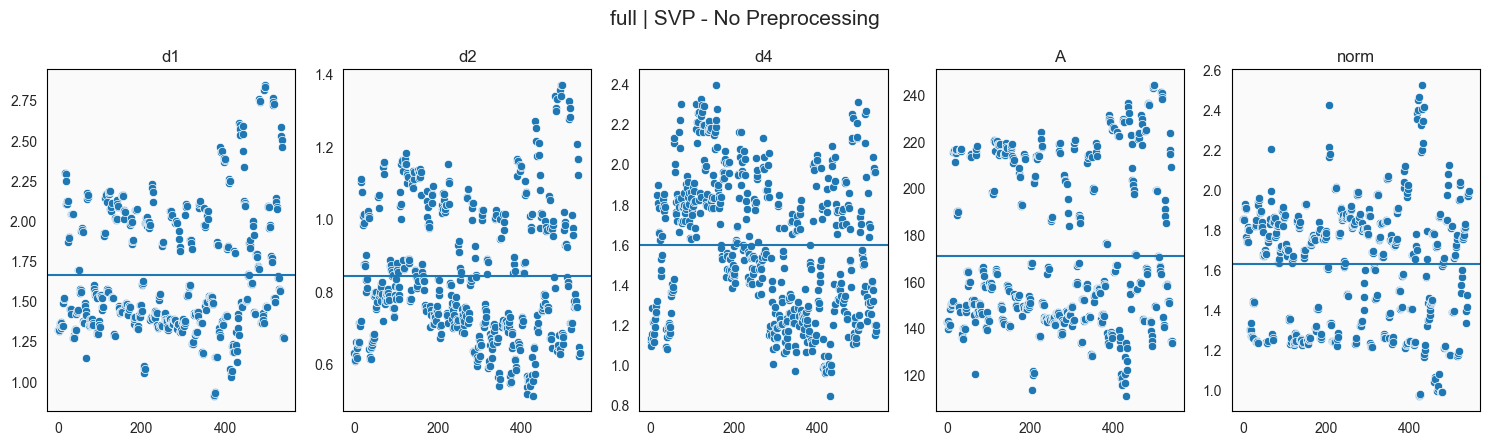

In [14]:
for selection in selections:
    
    selected_df = selections[selection]['raw_df']
    SAMPLE_TYPE = f'{selection}'
    plot_svp(selected_df, title=f'{selection} | SVP - No Preprocessing')
    plt.show()
    plt.close()

## identify outlier samples

most samples are within 1.2 to 2.2

False    508
True      34
Name: norm, dtype: int64
Number of samples outside the range: 50


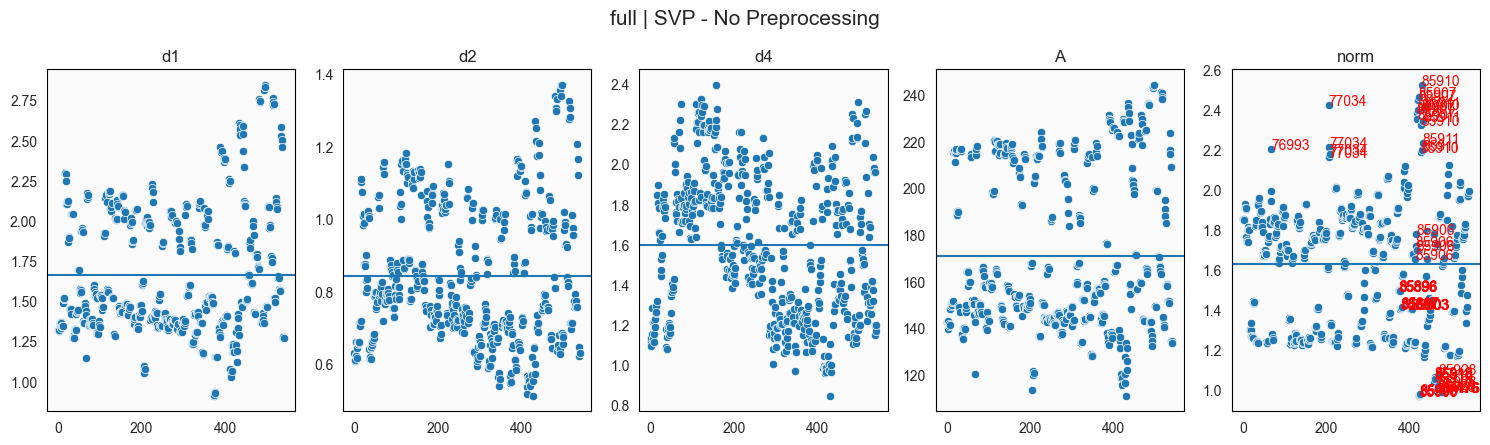

In [45]:
for selection in selections:

    output_dir = Path(f"../data/visualisation/{selection}/")
    output_dir.mkdir(exist_ok=True, parents=True)

    selected_df = selections[selection]['raw_df']
    selected_labels = selections[selection]['label_df']

    plot_svp(selected_df, title=f'{selection} | SVP - No Preprocessing')

    svp_arr = spectral_vector_properties(selected_df, True)

    #metrics cutoff
    metrics = {
        0 : 'd1',
        1 : 'd2',
        2 : 'd4',
        3 : 'A',
        4 : 'norm'
    }
    choice = 4
    maxval = 2.15
    minval = 1.15

    norm_data = svp_arr[metrics[choice]]

    anomalous_mask = (svp_arr[metrics[choice]] < minval) | (svp_arr[metrics[choice]] > maxval)
    print(anomalous_mask.value_counts())

    norm_ax = plt.gcf().axes[choice]

    count = 0

    for idx in range(len(norm_data)):
        if norm_data.iloc[idx] < minval or norm_data.iloc[idx] > maxval:  
            norm_ax.text(idx, norm_data.iloc[idx], norm_data.index[idx], 
                        fontsize=10, color='red')
            count += 1
        elif norm_data.index[idx] in [85896, 85897,85903,85906]:
            norm_ax.text(idx, norm_data.iloc[idx], norm_data.index[idx], 
                        fontsize=10, color='red')
            count += 1

    print(f"Number of samples outside the range: {count}")
            
    plt.savefig(output_dir / f"{selection}_svp.png")
    plt.show()
    plt.close()

Processing full dataset
(542, 191) (542, 3)
False    508
True      34
Name: norm, dtype: int64


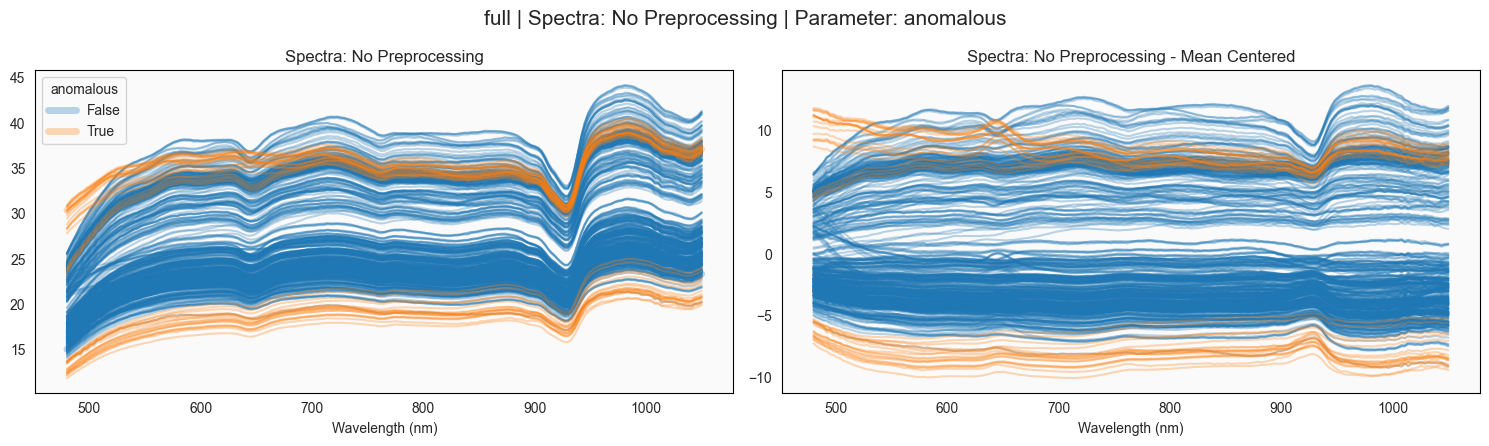

In [46]:
for selection in selections:
    SAMPLE_TYPE = f'{selection}'

    print(f'Processing {selection} dataset')
    selected_df = selections[selection]['raw_df']
    selected_labels = selections[selection]['label_df']
    print(selected_df.shape, selected_labels.shape)

    svp_arr = spectral_vector_properties(selected_df, True)

    metrics = {
        0 : 'd1',
        1 : 'd2',
        2 : 'd4',
        3 : 'A',
        4 : 'norm'
    }
    choice = 4
    maxval = 2.15
    minval = 1.15

    anomalous_mask = (svp_arr[metrics[choice]] < minval) | (svp_arr[metrics[choice]] > maxval)
    print(anomalous_mask.value_counts())

    # add a new column in check_df to label anomalous samples
    check_df = selected_df.copy(deep=True)
    check_df['anomalous'] = anomalous_mask
    # display(check_df[check_df['anomalous'] == True])

    plot_spectra(selected_df, labels=check_df[['anomalous']],
                spec_prep=PREPROCESSING,
                sample_type=SAMPLE_TYPE,
                cmap=cmap)
    plt.show()
    plt.close()

## filter outliers


Processing full dataset
(542, 191) (542, 2)
Number of anomalous samples: 50


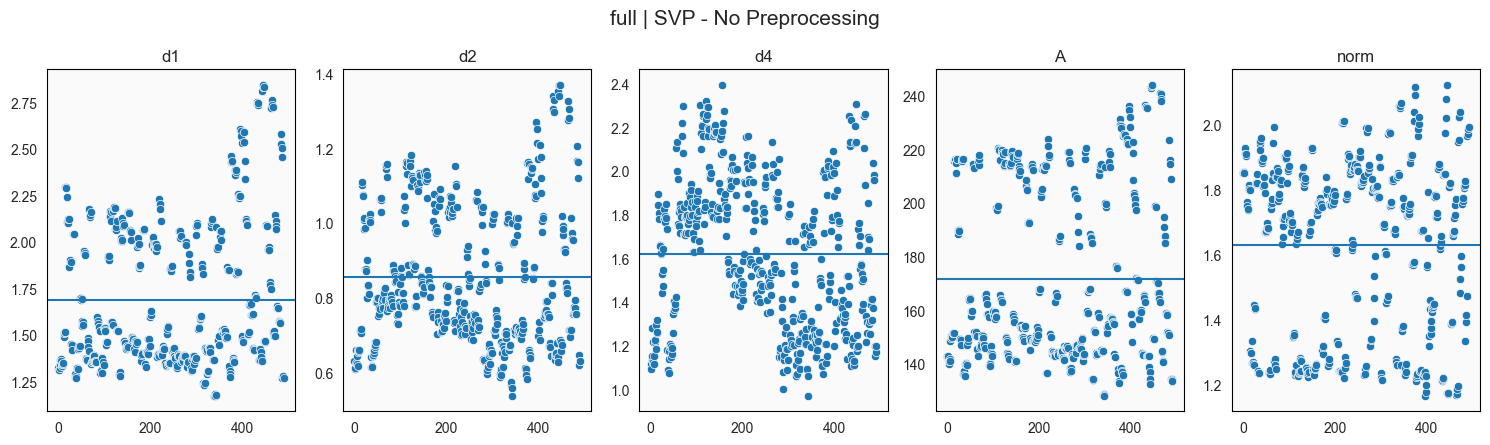

shapes after cleaning: (492, 191) (492, 2)


In [66]:
for selection in selections:

    output_dir = Path(f"../data/processed/")
    output_dir.mkdir(exist_ok=True, parents=True)

    print(f'\nProcessing {selection} dataset')
    selected_df = selections[selection]['raw_df']
    selected_labels = selections[selection]['label_df'].set_index('lot_id')
    print(selected_df.shape, selected_labels.shape)

    svp_arr = spectral_vector_properties(selected_df, True)

    metrics = {
        0 : 'd1',
        1 : 'd2',
        2 : 'd4',
        3 : 'A',
        4 : 'norm'
    }
    choice = 4
    maxval = 2.15
    minval = 1.15

    anomalous_mask = (svp_arr[metrics[choice]] < minval) | (svp_arr[metrics[choice]] > maxval)

    cleaned_df = selected_df[~anomalous_mask]
    cleaned_labels = selected_labels[~anomalous_mask]

    count = 0
    for index in [85896, 85897,85903,85906]:
        cleaned_labels = cleaned_labels.drop(index)
        cleaned_df = cleaned_df.drop(index)
        count += 4

    print(f'Number of anomalous samples: {anomalous_mask.sum() + count}')

    
    SAMPLE_TYPE = f'{selection}'
    plot_svp(cleaned_df, title=f'{selection} | SVP - No Preprocessing')
    plt.show()
    plt.close()

    print(f'shapes after cleaning: {cleaned_df.shape} {cleaned_labels.shape}')

    cleaned_df.to_csv(output_dir/f"cleaned_input_{selection}_{pulldate}.csv")
    cleaned_labels.to_csv(output_dir/f"cleaned_label_{selection}_{pulldate}.csv")